In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 
import warnings 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

## Question 1
#### Find a vector **w** and bias **b**, please show the calculation step by step as same as example 1, if the support vectors are (1.5, -0.5) and (2,-2)

Weights: [[0.3235295]
 [1.2941175]]
Biases: 1.2941174623947564
Alphas: [[3.04776812e-08]
 [2.05882356e-01]
 [6.37073937e-08]
 [1.10139522e-08]
 [9.99999933e-01]
 [7.94117555e-01]]
Weights: [[0.3235295]
 [1.2941175]]
Biases: 1.2941174623947564
Alphas: [[3.04776812e-08]
 [2.05882356e-01]
 [6.37073937e-08]
 [1.10139522e-08]
 [9.99999933e-01]
 [7.94117555e-01]]
Accuracy: 1.0


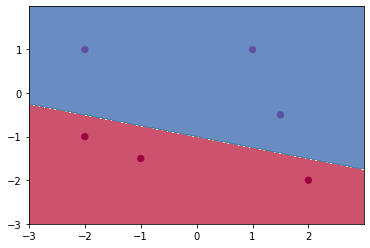

In [25]:
import cvxopt
from sklearn import datasets

def linear(x, z):
    return np.dot(x, z.T)

def polynomial(x, z, p=5):
    return (1 + np.dot(x, z.T)) ** p

def gaussian(x, z, sigma = 0.1):
    return np.exp(-np.linalg.norm(x - z, axis=1) ** 2 / (2 * (sigma ** 2)))

def plot_contour(X, y, svm):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    points = np.c_[xx.ravel(), yy.ravel()]
    Z = svm.predict(points)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s = 40, cmap = plt.cm.Spectral)


class SVM:
    def __init__(self, kernel = gaussian, C = 1):
        self.kernel = kernel
        self.C = C

    def fit(self, X, y):
        self.y = y
        self.X = X
        m, n = X.shape

        self.K = np.zeros((m, m))
        for i in range(m):
            self.K[i, :] = self.kernel(X[i, np.newaxis], self.X)

        P = cvxopt.matrix(np.outer(y, y) * self.K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m) * -1, np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y, (1, m), "d")
        b = cvxopt.matrix(np.zeros(1))
        cvxopt.solvers.options['show_progress'] = False
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])

    def predict(self, X): 
        y_predict = np.zeros((X.shape[0]))
        sv, w, b, alphas = self.get_parameters(self.alphas)

        for i in range(X.shape[0]):
            y_predict[i] = np.sum(
                self.alphas[sv]
                * self.y[sv, np.newaxis]
                * self.kernel(X[i], self.X[sv])[:, np.newaxis]
            )
        print(f'Weights: {w}')
        print(f'Biases: {b}')
        print(f'Alphas: {alphas}')
        return np.sign(y_predict + self.b)

    def get_parameters(self, alphas):
        threshold = 1e-5

        sv = ((alphas > threshold) * (alphas < self.C)).flatten()
        self.w = np.dot(self.X[sv].T, alphas[sv] * self.y[sv, np.newaxis])
        self.b = np.mean(
            self.y[sv, np.newaxis]
            - self.alphas[sv] * self.y[sv, np.newaxis] * self.K[sv, sv][:, np.newaxis]
        )
        return sv, self.w, self.b, self.alphas
    
if __name__ == "__main__":
    X = np.array([[-2, 1], [-2, -1], [-1, -1.5], [1, 1], [1.5, -0.5],[2, -2]] )
    y = np.array([1, -1, -1, 1, 1, -1])
    
    svm = SVM(kernel = linear)
    svm.fit(X, y)
    y_pred = svm.predict(X)
    plot_contour(X, y, svm)
    print(f"Accuracy: {sum(y == y_pred) / y.shape[0]}")


In [37]:
X = np.array([[-2, 1], [-2, -1], [-1, -1.5], [1, 1], [1.5, -0.5],[2, -2]] )
y = np.array([1, -1, -1, 1, 1, -1])

equation = []
for x1 in X:
    for idx, x2 in enumerate(X):
        print(np.dot(x1, x2))
        if idx == 5:
            print()

5.0
3.0
0.5
-1.0
-3.5
-6.0

3.0
5.0
3.5
-3.0
-2.5
-2.0

0.5
3.5
3.25
-2.5
-0.75
1.0

-1.0
-3.0
-2.5
2.0
1.0
0.0

-3.5
-2.5
-0.75
1.0
2.5
4.0

-6.0
-2.0
1.0
0.0
4.0
8.0



## Question 2
#### Create a SVM-model and plot a 2D-SVM classification by using Python and colon data set (use only two genes, T62947 and H64807), and find your best hyper-parameters for precision, recall, and accuracy. <code>(Training:Testing = 80:20)</code>

In this section, we only used two features called <code>T62947</code> and <code>H64807</code>. Hence, the number of samples <code>m = 62</code> is greater than the number of features <code>n = 2</code>. The class distribution, however, is imbalanced with 22 patients having cancer while 40 patients having no cancer. Hence, it is important to perform resampling techniques (i.e., undersampling, oversampling, SMOTE). 

In addition, we normalize the given dataset through standardization by removing the mean and scaling to unit variance. We also split the data into 80:20 ratio between training and testing sets.

In [3]:
df_colon = pd.read_csv('../data/colon.csv')
XX = df_colon[['T62947', 'H64807']]
yy = df_colon['Class']

XX, yy = XX.to_numpy(), yy.to_numpy()
yy = yy.flatten()

smote = SMOTE()
X, y = smote.fit_resample(XX, yy)

random.seed(413)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

Let's try to visualize the class distribution with and without resampling (i.e., SMOTE method).

Text(0.5, 1.0, 'SMOTE Resampling')

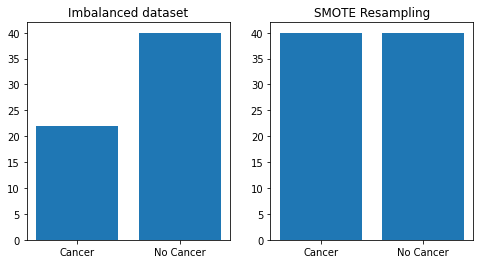

In [4]:
x = np.arange(2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))

ax1.bar(x, height = [len(yy[yy == 1]), len(yy[yy == -1])])
ax1.set_xticks(x, ['Cancer', 'No Cancer'])
ax1.set_title('Imbalanced dataset')

ax2.bar(x, height = [len(y[y == 1]), len(y[y == -1])])
ax2.set_xticks(x, ['Cancer', 'No Cancer'])
ax2.set_title('SMOTE Resampling')

We created a Python function called <code>plot_data</code> to visually create the scatter plot of the features between two classes. We labeled the two classes <code>i.e., (y = -1, y = 1)</code> as 'No Cancer' and 'Cancer' patients, respectively. Patients with no cancer are highlighted as color blue while patients without cancer are colored as red dots.

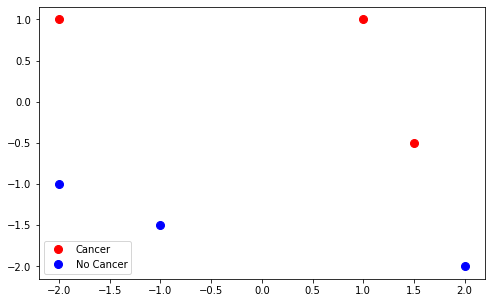

In [6]:
def plot_data(X, y):
    y = y.flatten()
    class1 = (y ==  1)
    class2 = (y == -1)
    plt.figure(figsize=(8, 5))    
    plt.plot(X[:,0][class1], X[:,1][class1], 'ro', markersize = 8, label = 'Cancer')
    plt.plot(X[:,0][class2], X[:,1][class2], 'bo', markersize = 8, label = 'No Cancer')
    plt.legend(loc = 'lower left')

plot_data(X, y)

We find the best hyper-parameters for precision, recall, and accuracy. We first initialized the parameters on a given range and types for kernel, gamma, and C. A 5-fold cross-validation was also adopted here.

In [6]:
tuned_parameters = [{'kernel': ['rbf'],     'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'],                                        'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]}]

scores = ['precision', 'recall']
random.seed(413)
for score in scores:
    clf = GridSearchCV(SVC(C = 1), tuned_parameters, cv = 5,
    scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

print('Best parameters set found on development set:')
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds  = clf.cv_results_['std_test_score']

Best parameters set found on development set:
{'C': 25, 'gamma': 1, 'kernel': 'rbf'}


The code below calculates the predictions <code>y_pred</code> from the testing set. We then used <code>y_pred</code> to create the confusion matrix and classification report.

<Figure size 1080x720 with 0 Axes>

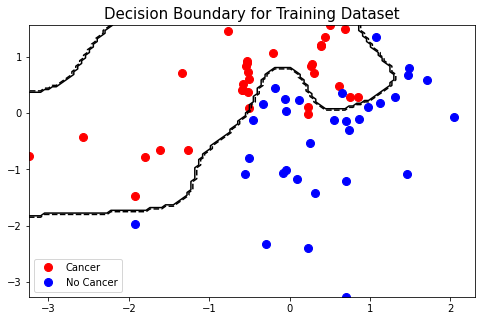

In [7]:
random.seed(413)
svclassifier = SVC(kernel = 'rbf', C = 50, gamma = 1)
svclassifier.fit(X_train, y_train)

def visualize_boundary(X, y, model, title):
    plt.figure(figsize = (15, 10))
    plot_data(X, y)
    X_21, X_22 = np.meshgrid(np.linspace(X[:,0].min(), X[:,1].max(), num = 100), 
                             np.linspace(X[:,1].min(), X[:,1].max(), num = 100))
    plt.contour(X_21, X_22, model.predict(np.array([X_21.ravel(),X_22.ravel()]).T).reshape(X_21.shape), 1, colors = 'k')
    plt.title(title, size = 15)
    plt.legend(loc = 'lower left')
    plt.show()

random.seed(413)
visualize_boundary(X_train, y_train, svclassifier, 
                            title = 'Decision Boundary for Training Dataset')

In [8]:
y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8 0]
 [1 7]]
              precision    recall  f1-score   support

          -1       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



### Conclusion:

## Section 3 
#### Train a SVM-model by using colon-data set and tuning the hyper-parameters, and select the best model. <code>(Training:Testing = 80:20)</code> and give your comments

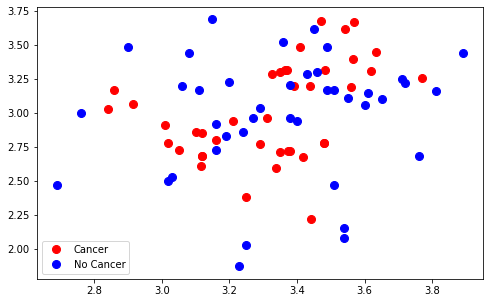

In [9]:
XX = df_colon.drop('Class', axis = 1)
yy = df_colon['Class']


X, y = smote.fit_resample(XX, yy)
X, y = X.to_numpy(), y.to_numpy()
y = y.flatten()

plot_data(X, y)

In [10]:
random.seed(413)
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

tuned_parameters = [{'kernel': ['rbf'],     'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'],                                              'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]}]

scoring = {
    'Precision': 'precision',
    'Recall': 'recall',
    'Accuracy': 'accuracy',
    'AUC': 'roc_auc',
    'F1': 'f1_micro'}
    
random.seed(413)
clf = GridSearchCV(
              SVC(), param_grid = tuned_parameters,
              scoring = scoring, refit = 'Recall',
              return_train_score = True)
clf.fit(X_train, y_train)
results = clf.cv_results_

print('Best parameters set found on development set:')
print(clf.best_params_)

Best parameters set found on development set:
{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}


In [20]:
random.seed(413)
svclassifier = SVC(kernel = 'rbf', C = 1000, gamma = 0.0001)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7 3]
 [0 6]]
              precision    recall  f1-score   support

          -1       1.00      0.70      0.82        10
           1       0.67      1.00      0.80         6

    accuracy                           0.81        16
   macro avg       0.83      0.85      0.81        16
weighted avg       0.88      0.81      0.81        16



### Support Vector Machines with Principal Component Analysis for Feature Selection

In [62]:
random.seed(413)
pca = PCA(n_components = 2)
pca.fit(X)
X_pca = pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size = 0.20)

In [63]:
tuned_parameters = [{'kernel': ['rbf'],     'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-7], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'],                                              'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]}]

scoring = {
    'Precision': 'precision',
    'Recall': 'recall',
    'Accuracy': 'accuracy',
    'AUC': 'roc_auc',
    'F1': 'f1_micro'}
    
random.seed(413)
clf = GridSearchCV(
              SVC(), param_grid = tuned_parameters,
              scoring = scoring, refit = 'Recall',
              return_train_score = True)
clf.fit(X_train, y_train)
results = clf.cv_results_

print('Best parameters set found on development set:')
print(clf.best_params_)

Best parameters set found on development set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


In [64]:
random.seed(413)
svclassifier = SVC(kernel = 'rbf', C = 10, gamma = 0.001)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[4 4]
 [1 7]]
              precision    recall  f1-score   support

          -1       0.80      0.50      0.62         8
           1       0.64      0.88      0.74         8

    accuracy                           0.69        16
   macro avg       0.72      0.69      0.68        16
weighted avg       0.72      0.69      0.68        16



<Figure size 1080x720 with 0 Axes>

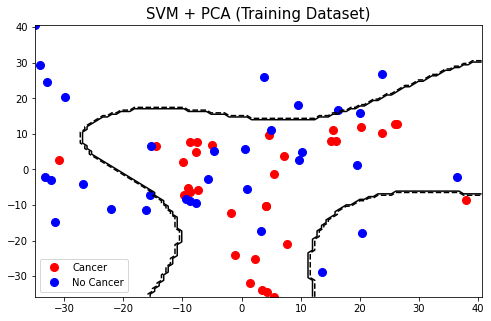

In [65]:
visualize_boundary(X_train, y_train, svclassifier, title = 'SVM + PCA (Training Dataset)')